In [10]:
import pandas as pd 
import numpy as np

selected_features = ["key", "mode", "time_signature", "duration_ms_x","danceability", "loudness", "energy", "instrumentalness", "liveness", "valence", "speechiness", "tempo"] 

df = pd.read_csv("rai.csv")
df = df.sort_values(by=['popularity'])
df = df.drop_duplicates(subset=['id'])
df = df.drop_duplicates(subset=['name', 'main_artist'], keep='first')
df = df.drop_duplicates(subset=selected_features, keep='first')

In [11]:
# TODO Radar chart: https://python-graph-gallery.com/390-basic-radar-chart/
df = df.groupby('main_artist').mean()
df.head()

,key,mode,time_signature,duration_ms_x,danceability,loudness,energy,instrumentalness,liveness,valence,speechiness,tempo,popularity,youtube_views,last_fm_playcount,last_fm_listeners
main_artist,,,,,,,,,,,,,,,,
Bilal Sghir,5.473684,0.245614,3.964912,336036.280702,0.579579,-4.969263,0.867526,0.000329,0.196065,0.796281,0.109923,114.851772,8.192982,2.032760e+06,11.596491,5.017544
Cheb Bello,4.800000,0.442857,4.000000,380517.400000,0.615914,-6.842800,0.828457,0.009939,0.233527,0.807371,0.113801,108.083929,14.585714,5.155333e+06,31.971429,8.242857
Cheb Bilal,5.708738,0.412621,3.883495,337756.820388,0.626461,-7.350709,0.775898,0.016164,0.209120,0.807058,0.067482,126.769883,3.762136,2.875840e+06,47.199029,21.922330
Cheb Djalil,5.487805,0.268293,4.000000,351968.829268,0.582402,-7.106671,0.831768,0.001247,0.237944,0.852512,0.077498,99.476402,7.378049,2.534287e+06,9.719512,3.390244
Cheb Hasni,4.763314,0.455621,3.781065,318014.136095,0.613438,-9.010592,0.676136,0.020195,0.172733,0.745888,0.063529,137.436485,5.065089,1.361711e+06,90.739645,37.745562


## Correlationsfigsize=

Text(0.5, 1.0, 'Rai songs - Audio features and popularity - Correlation matrix')

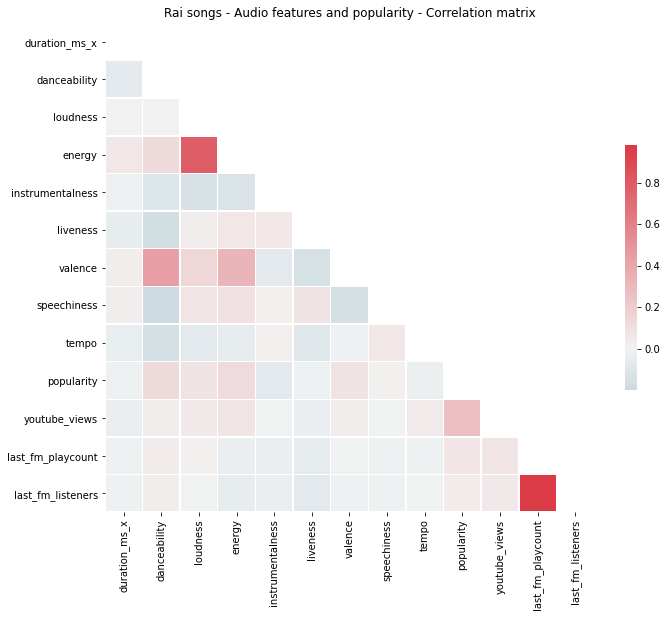

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df.loc[:, 'duration_ms_x':'last_fm_listeners']
df = df.infer_objects()
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
ax.set_title("Rai songs - Audio features and popularity - Correlation matrix")